In [1]:
#Import Library
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import requests
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, GRU

In [2]:
#global variable
NUM_WORDS = 1000
OOV_TOKEN = "<OOV>"
PADDING = 'post'
MAXLEN = 120
EMBEDDING_DIM = 16

In [3]:
#Retrieve DS from Github
dataset_link = 'https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv'
response = requests.get(dataset_link)

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/Willie29/capstone-C23-PS056/main/ML/Dataset_Combined.csv')
# Identify Unnamed columns
unnamed_columns = [col for col in data.columns if 'Unnamed' in col]

# Drop Unnamed columns
data = data.drop(unnamed_columns, axis=1)
#shuffle data
data = data.sample(frac=1)

print(data.head())
print("\n")
print(data.tail())

       Label                                              Tweet
1153  Non_HS                   alia dm benda ni kt aku hahahaha
3437      HS              eh bangsat ribut yuk sini sama gua !!
3105      HS  Sakit di otak sama hatinya itu mah dia. Udah g...
74    Non_HS                        nangis nangis ketonjok lagi
2051      HS  pokok pulang solo cebur habitat nya kolam bute...


       Label                                              Tweet
1753  Non_HS  Anjing dapat menjadi pendengar yang baik dan t...
1605  Non_HS  Ketika saya pulang, anjing saya dengan riang m...
942   Non_HS                    aku meratapi hidup dengan chill
3226      HS  demi tuhan lu semua berantem mulu anjing ngapa...
784   Non_HS                      aku balik ngefans lagi wkwkwk


In [5]:
data['Label'].value_counts()

Non_HS    1789
HS        1722
Name: Label, dtype: int64

In [6]:
def parse_data(data):
    labels = []
    tweets = []

    for _, row in data.iterrows():
        cond = (0 if row['Label'] == "HS" else 1)
        labels.append(cond)
        tweets.append(row['Tweet'])

    return labels, tweets

# Assuming 'data' is your DataFrame
labels, tweets = parse_data(data)

In [7]:
print(f"Example number in dataset is {len(tweets)} examples\n")

print(f"2nd example:\n{tweets[1]}\n")
print(f"Last example:\n{tweets[-1]}")

Example number in dataset is 3511 examples

2nd example:
eh bangsat ribut yuk sini sama gua !!

Last example:
aku balik ngefans lagi wkwkwk


In [8]:
#90-10 ratio train-test
def train_test_split(labels,tweets):
    train_size = int(len(tweets) * 0.9)

    train_labels = labels[:train_size]
    train_tweets = tweets[:train_size]

    test_labels = labels[train_size:]
    test_tweets = tweets[train_size:]

    return train_labels, train_tweets, test_labels, test_tweets

In [9]:
train_labels, train_tweets, test_labels, test_tweets = train_test_split(labels, tweets)

print(f" {len(train_labels)} sentences for training.")
print(f" {len(train_tweets)} labels for training.")
print(f" {len(test_labels)} sentences for validation.")
print(f" {len(test_tweets)} labels for validation.")

 3159 sentences for training.
 3159 labels for training.
 352 sentences for validation.
 352 labels for validation.


In [10]:
print(train_tweets[:3])
print(train_labels[:3])
print(test_tweets[:3])
print(test_labels[:3])

['alia dm benda ni kt aku hahahaha', 'eh bangsat ribut yuk sini sama gua !!', 'Sakit di otak sama hatinya itu mah dia. Udah gak ada nurani dan urat malunya. Pajak saya loh yang ngegaji orang2 gila hormat ini']
[1, 0, 0]
['syahadat allah subhanahu wa taala dungu biadab bangsa rusak fahri', 'sarah gtayang hahahah tersasul panggil sayang hahahahah lawak abang ipar aku ni', 'yang Ahokers, Klo gak seneng ama cuitan gw silahkan unfollow karena gw Anti AHOK (Si Penista Agama Islam)']
[0, 1, 0]


In [11]:
#tokenizer function
def fit_tokenizer(train_sentences, num_words, oov_token):
    tokenizer = Tokenizer(num_words = num_words, oov_token = oov_token)
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [12]:
#buat test doang
def lowercase(list_sentence):
    lower_sentence = list_sentence
    for i in range(len(list_sentence)):
        lower_sentence[i] = lower_sentence[i].lower()
    return lower_sentence

In [13]:
#tokenize sentence
#test_tweets1 = test_tweets[0].lower()
#test_tweets1 = test_tweets1.lower()
lower_train_tweets = lowercase(train_tweets)
tokenizer = fit_tokenizer(lower_train_tweets, NUM_WORDS, OOV_TOKEN)
word_index = tokenizer.word_index
print(f"Vocabulary contains {len(word_index)} words\n")
print("<OOV> token included in vocabulary" if "<OOV>" in word_index else "<OOV> token NOT included in vocabulary")

Vocabulary contains 8559 words

<OOV> token included in vocabulary


In [14]:
#seq and padding function
def seq_and_pad(sentences, tokenizer, padding, maxlen):
    sequences = tokenizer.texts_to_sequences(sentences)
    padded_sequences = pad_sequences(sequences, maxlen = maxlen, padding = padding)
    return padded_sequences

In [15]:
#seq and padding sentence
lower_val_tweets = lowercase(test_tweets)
train_padded_seq = seq_and_pad(lower_train_tweets, tokenizer, PADDING, MAXLEN)
val_padded_seq = seq_and_pad(lower_val_tweets, tokenizer, PADDING, MAXLEN)
print(f"Padded training sequences have shape: {train_padded_seq.shape}\n")
print(f"Padded validation sequences have shape: {val_padded_seq.shape}")

Padded training sequences have shape: (3159, 120)

Padded validation sequences have shape: (352, 120)


In [16]:
#Model Structure
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length = MAXLEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 32, activation= 'relu'),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])

In [17]:
print(type(test_labels))

<class 'list'>


In [18]:
test_labels_changed = np.array(test_labels)
print(type(test_labels_changed))
print(type(train_padded_seq))
print(type(val_padded_seq))
print(type(train_labels))
print("\n")
print(train_padded_seq)
print("\n")
print(val_padded_seq)
print(test_labels_changed[:10])

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'list'>


[[  1   1 437 ...   0   0   0]
 [162  39 469 ...   0   0   0]
 [185   7 149 ...   0   0   0]
 ...
 [269   4 234 ...   0   0   0]
 [  4  71 150 ...   0   0   0]
 [ 52 526  26 ...   0   0   0]]


[[  1  81   1 ...   0   0   0]
 [  1   1   1 ...   0   0   0]
 [  2   1 189 ...   0   0   0]
 ...
 [  3   1 104 ...   0   0   0]
 [331 123  52 ...   0   0   0]
 [  3 718   1 ...   0   0   0]]
[0 1 0 1 1 0 1 0 1 0]


In [19]:
train_labels_changed = np.array(train_labels)
print(train_labels_changed)

[1 0 0 ... 1 0 0]


In [20]:
# Menggunakan LabelEncoder untuk mengubah label menjadi bilangan bulat
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels_changed)
test_labels_encoded = label_encoder.transform(test_labels_changed)

# Mengubah label menjadi one-hot encoded
num_classes = len(label_encoder.classes_)
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_encoded, num_classes=num_classes)
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_encoded, num_classes=num_classes)

In [21]:
print(train_labels_encoded)
print("\n")
print(test_labels_encoded)
print("\n")
print(train_labels_one_hot)
print("\n")
print(test_labels_one_hot)

[1 0 0 ... 1 0 0]


[0 1 0 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0
 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 0 1 1 1 0
 0 0 0 1 1 0 1 0 1 1 0 1 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 0 0 0 1
 1 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 0 1 0 0 0 1 0 1 1 1 1 0 0 1
 1 1 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 1 0
 0 0 0 0 1 0 0 1 1 0 0 0 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0 1
 1 0 1 0 0 1 1 0 1 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1 0 1 0 1 0
 0 0 1 0 1 0 0 1 1 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 1 0 1
 0 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 0 1]


[[0. 1.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [1. 0.]]


[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0

In [22]:
model.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

history_1 = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
99/99 [==============================] - 3s 9ms/step - loss: 0.6926 - accuracy: 0.5065 - val_loss: 0.6900 - val_accuracy: 0.5739
Epoch 2/30
99/99 [==============================] - 1s 6ms/step - loss: 0.6879 - accuracy: 0.6157 - val_loss: 0.6827 - val_accuracy: 0.7926
Epoch 3/30
99/99 [==============================] - 1s 6ms/step - loss: 0.6663 - accuracy: 0.7072 - val_loss: 0.6443 - val_accuracy: 0.6250
Epoch 4/30
99/99 [==============================] - 1s 9ms/step - loss: 0.6142 - accuracy: 0.7629 - val_loss: 0.5922 - val_accuracy: 0.8182
Epoch 5/30
99/99 [==============================] - 1s 10ms/step - loss: 0.5272 - accuracy: 0.8367 - val_loss: 0.5151 - val_accuracy: 0.8381
Epoch 6/30
99/99 [==============================] - 1s 11ms/step - loss: 0.4447 - accuracy: 0.8575 - val_loss: 0.4685 - val_accuracy: 0.8239
Epoch 7/30
99/99 [==============================] - 1s 8ms/step - loss: 0.3891 - accuracy: 0.8563 - val_loss: 0.4119 - val_accuracy: 0.8523
Epoch 8/30
99/99 [

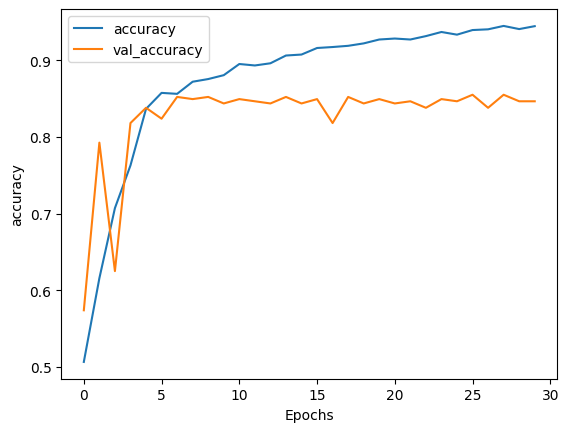

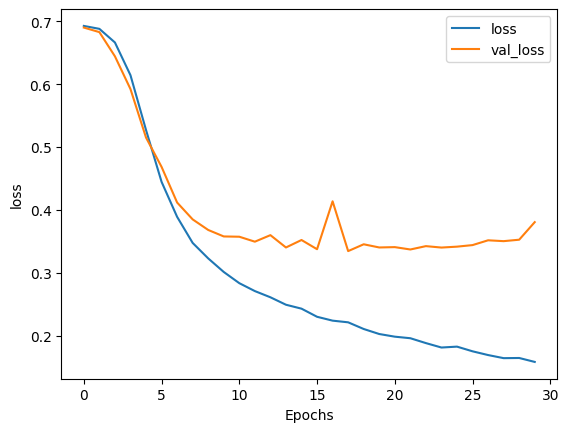

In [23]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_graphs(history_1, "accuracy")
plot_graphs(history_1, "loss")

In [24]:
seed_text = "anjing liar"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.10367086 0.8963291 ]]


In [25]:
model_LSTM = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length = MAXLEN),
    tf.keras.layers.Bidirectional(LSTM(16, return_sequences= True)),
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences= True)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(units = 32, activation= 'relu'),
    tf.keras.layers.Dense(units = 2, activation='softmax')
])
model_LSTM.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam() ,metrics=['accuracy'])

history_LSTM = model_LSTM.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
99/99 [==============================] - 29s 202ms/step - loss: 0.6929 - accuracy: 0.5081 - val_loss: 0.6915 - val_accuracy: 0.5852
Epoch 2/30
99/99 [==============================] - 20s 199ms/step - loss: 0.4930 - accuracy: 0.7854 - val_loss: 0.4617 - val_accuracy: 0.8210
Epoch 3/30
99/99 [==============================] - 19s 187ms/step - loss: 0.3799 - accuracy: 0.8490 - val_loss: 0.4449 - val_accuracy: 0.8011
Epoch 4/30
99/99 [==============================] - 21s 213ms/step - loss: 0.4143 - accuracy: 0.8376 - val_loss: 0.4573 - val_accuracy: 0.7983
Epoch 5/30
99/99 [==============================] - 19s 188ms/step - loss: 0.3533 - accuracy: 0.8534 - val_loss: 0.4158 - val_accuracy: 0.8409
Epoch 6/30
99/99 [==============================] - 20s 200ms/step - loss: 0.4024 - accuracy: 0.8332 - val_loss: 0.4894 - val_accuracy: 0.8097
Epoch 7/30
99/99 [==============================] - 18s 185ms/step - loss: 0.3435 - accuracy: 0.8756 - val_loss: 0.4316 - val_accuracy: 0.8381

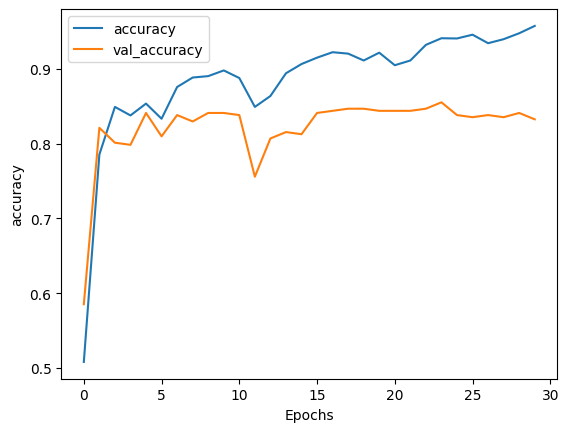

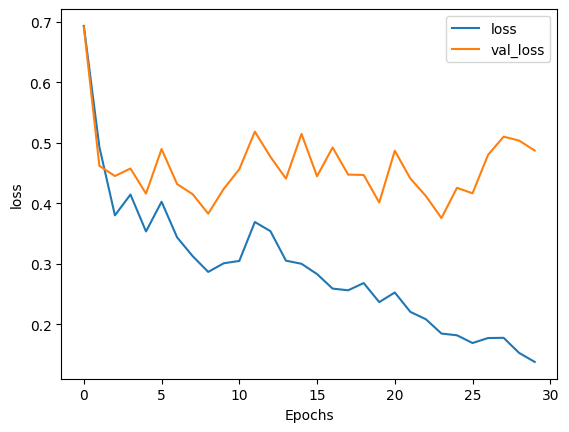

In [26]:
plot_graphs(history_LSTM, "accuracy")
plot_graphs(history_LSTM, "loss")

In [27]:
seed_text = "muka lu kayak anjing"
# Convert the text into sequences
token_list = tokenizer.texts_to_sequences([seed_text])[0]
# Pad the sequences
token_list = pad_sequences([token_list], maxlen=MAXLEN , padding='pre')
# Get the probabilities of predicting a word
predicted = model_LSTM.predict(token_list, verbose=0)
print("[HS             ,      non-HS]")
print(predicted)

[HS             ,      non-HS]
[[0.05133926 0.9486607 ]]


In [28]:
model.get_weights()

[array([[ 0.11678475, -0.05239008,  0.11064832, ..., -0.09083903,
          0.06573542,  0.00301052],
        [ 0.11637454, -0.04769501,  0.03812576, ..., -0.1288491 ,
          0.11335062, -0.02554837],
        [ 0.03629287,  0.04224022,  0.02496132, ..., -0.1323111 ,
          0.01502402,  0.08575103],
        ...,
        [-0.02297094,  0.02419313,  0.07395596, ...,  0.05181952,
          0.02500454,  0.02258706],
        [-0.08972359,  0.13890661, -0.1325895 , ..., -0.1448655 ,
         -0.08489574,  0.08033835],
        [-0.2728111 ,  0.3138379 , -0.334846  , ..., -0.30013838,
         -0.37657526,  0.33525243]], dtype=float32),
 array([[-2.28743926e-01,  9.77054089e-02, -1.57255784e-01,
          3.35268304e-02, -3.66236597e-01, -2.57939875e-01,
         -3.00254911e-01,  3.17431837e-02,  4.99723524e-01,
          1.21633269e-01,  2.69831002e-01, -2.59681910e-01,
          4.10040677e-01, -3.10345858e-01, -3.22506636e-01,
         -3.46317351e-01,  4.26379889e-01, -2.33006895e-01

In [31]:
# Struktur model dengan GRU, Optimizer Adam
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.GRU(units=32, return_sequences=True),
    tf.keras.layers.GRU(units=16),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
99/99 [==============================] - 21s 135ms/step - loss: 0.6938 - accuracy: 0.4919 - val_loss: 0.6945 - val_accuracy: 0.4318
Epoch 2/30
99/99 [==============================] - 12s 125ms/step - loss: 0.6934 - accuracy: 0.4910 - val_loss: 0.6919 - val_accuracy: 0.5682
Epoch 3/30
99/99 [==============================] - 12s 122ms/step - loss: 0.6934 - accuracy: 0.4872 - val_loss: 0.6922 - val_accuracy: 0.5682
Epoch 4/30
99/99 [==============================] - 12s 116ms/step - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.6940 - val_accuracy: 0.4318
Epoch 5/30
99/99 [==============================] - 12s 119ms/step - loss: 0.6933 - accuracy: 0.4973 - val_loss: 0.6925 - val_accuracy: 0.5682
Epoch 6/30
99/99 [==============================] - 12s 124ms/step - loss: 0.6933 - accuracy: 0.4840 - val_loss: 0.6930 - val_accuracy: 0.5682
Epoch 7/30
99/99 [==============================] - 12s 126ms/step - loss: 0.6933 - accuracy: 0.5002 - val_loss: 0.6932 - val_accuracy: 0.4318

In [32]:
# Struktur model dengan GRU Optimizer SGD
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(NUM_WORDS, EMBEDDING_DIM, input_length=MAXLEN),
    tf.keras.layers.GRU(units=32, return_sequences=True),
    tf.keras.layers.GRU(units=16),
    tf.keras.layers.Dense(units=2, activation='softmax')
])

model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(), metrics=['accuracy'])

history = model.fit(train_padded_seq, train_labels_one_hot, epochs=30, validation_data=(val_padded_seq, test_labels_one_hot))

Epoch 1/30
99/99 [==============================] - 17s 131ms/step - loss: 0.6933 - accuracy: 0.4926 - val_loss: 0.6933 - val_accuracy: 0.4318
Epoch 2/30
99/99 [==============================] - 12s 123ms/step - loss: 0.6933 - accuracy: 0.4884 - val_loss: 0.6929 - val_accuracy: 0.5682
Epoch 3/30
99/99 [==============================] - 12s 120ms/step - loss: 0.6933 - accuracy: 0.4998 - val_loss: 0.6930 - val_accuracy: 0.5682
Epoch 4/30
99/99 [==============================] - 12s 116ms/step - loss: 0.6933 - accuracy: 0.4967 - val_loss: 0.6927 - val_accuracy: 0.5682
Epoch 5/30
99/99 [==============================] - 12s 118ms/step - loss: 0.6933 - accuracy: 0.4948 - val_loss: 0.6925 - val_accuracy: 0.5682
Epoch 6/30
99/99 [==============================] - 12s 122ms/step - loss: 0.6932 - accuracy: 0.5027 - val_loss: 0.6932 - val_accuracy: 0.4318
Epoch 7/30
99/99 [==============================] - 12s 123ms/step - loss: 0.6932 - accuracy: 0.4967 - val_loss: 0.6918 - val_accuracy: 0.5682

In [33]:
# Membekukan lapisan dan menambahkan lapisan
# Mengubah representasi label asli menjadi kelas tunggal
train_labels_single = np.argmax(train_labels_one_hot, axis=1)
test_labels_single = np.argmax(test_labels_one_hot, axis=1)

# Membekukan lapisan-lapisan pada model dasar
for layer in model.layers:
    layer.trainable = False

# Menambahkan lapisan baru di atas model dasar
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Melatih model fine-tuning
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history_fine_tuning = model.fit(train_padded_seq, train_labels_single, epochs=30, validation_data=(val_padded_seq, test_labels_single))

# Evaluasi model fine-tuning
loss, accuracy = model.evaluate(val_padded_seq, test_labels_single)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/30
99/99 [==============================] - 7s 32ms/step - loss: 0.6937 - accuracy: 0.5030 - val_loss: 0.6924 - val_accuracy: 0.5682
Epoch 2/30
99/99 [==============================] - 3s 34ms/step - loss: 0.6937 - accuracy: 0.4897 - val_loss: 0.6923 - val_accuracy: 0.5682
Epoch 3/30
99/99 [==============================] - 3s 29ms/step - loss: 0.6934 - accuracy: 0.4995 - val_loss: 0.6962 - val_accuracy: 0.4318
Epoch 4/30
99/99 [==============================] - 3s 26ms/step - loss: 0.6935 - accuracy: 0.4976 - val_loss: 0.6955 - val_accuracy: 0.4318
Epoch 5/30
99/99 [==============================] - 2s 24ms/step - loss: 0.6935 - accuracy: 0.4992 - val_loss: 0.6908 - val_accuracy: 0.5682
Epoch 6/30
99/99 [==============================] - 3s 25ms/step - loss: 0.6936 - accuracy: 0.4884 - val_loss: 0.6907 - val_accuracy: 0.5682
Epoch 7/30
99/99 [==============================] - 4s 37ms/step - loss: 0.6937 - accuracy: 0.4929 - val_loss: 0.6897 - val_accuracy: 0.5682
Epoch 8/30
99

In [34]:
# Membekukan lapisan dan menambahkan lapisan optimizer SGD
# Mengubah representasi label asli menjadi kelas tunggal
train_labels_single = np.argmax(train_labels_one_hot, axis=1)
test_labels_single = np.argmax(test_labels_one_hot, axis=1)

# Membekukan lapisan-lapisan pada model dasar
for layer in model.layers:
    layer.trainable = False

# Menambahkan lapisan baru di atas model dasar (Optimizer = 'sgd')

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Melatih model fine-tuning
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
history_fine_tuning = model.fit(train_padded_seq, train_labels_single, epochs=30, validation_data=(val_padded_seq, test_labels_single))

# Evaluasi model fine-tuning
loss, accuracy = model.evaluate(val_padded_seq, test_labels_single)
print(f"Loss: {loss}")
print(f"Accuracy: {accuracy}")

Epoch 1/30
99/99 [==============================] - 9s 47ms/step - loss: 0.6938 - accuracy: 0.4897 - val_loss: 0.6906 - val_accuracy: 0.5682
Epoch 2/30
99/99 [==============================] - 3s 26ms/step - loss: 0.6935 - accuracy: 0.4941 - val_loss: 0.6901 - val_accuracy: 0.5682
Epoch 3/30
99/99 [==============================] - 3s 27ms/step - loss: 0.6935 - accuracy: 0.5030 - val_loss: 0.6905 - val_accuracy: 0.5682
Epoch 4/30
99/99 [==============================] - 3s 27ms/step - loss: 0.6933 - accuracy: 0.4922 - val_loss: 0.6920 - val_accuracy: 0.5682
Epoch 5/30
99/99 [==============================] - 4s 37ms/step - loss: 0.6934 - accuracy: 0.5021 - val_loss: 0.6946 - val_accuracy: 0.4318
Epoch 6/30
99/99 [==============================] - 3s 27ms/step - loss: 0.6935 - accuracy: 0.4900 - val_loss: 0.6939 - val_accuracy: 0.4318
Epoch 7/30
99/99 [==============================] - 3s 27ms/step - loss: 0.6934 - accuracy: 0.4929 - val_loss: 0.6907 - val_accuracy: 0.5682
Epoch 8/30
99